# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/VGG16_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)
The train shape is: (130, 513)
The test shape is: (33, 513)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5         6  \
41001 201546 -0.771757  0.0 -0.230502  0.335927 -0.505152  0.0 -0.244196   
      201547 -0.771757  0.0 -0.230502  0.335927 -0.505152  0.0 -0.244196   
      201548 -0.771757  0.0 -0.230502  0.335927 -0.505152  0.0 -0.244196   
      201549 -0.771757  0.0 -0.230502  0.335927 -0.505152  0.0 -0.244196   
      201550 -0.771757  0.0 -0.230502  0.335927 -0.505152  0.0 -0.244196   

                     7         8        9  ...       503       504      505  \
41001 201546 -0.280545 -0.218764 -0.10997  ...  0.583271 -0.357253 -0.29958   
      201547 -0.280545 -0.218764 -0.10997  ...  0.583271 -0.357253 -0.29958   
      201548 -0.280545 -0.218764 -0.10997  ...  0.583271 -0.357253 -0.29958   
      201549 -0.280545 -0.218764 -0.10997  ...  0.583271 -0.357253 -0.29958   
      201550 -0.280545 -0.218764 -0.10997  ...  0.583271 -0.357253 -0.29958   

                   506      507       508       509       510  511    Labels  
41001 201546  0.446741 -0.60308 -0.027746 -0.295077  0.020599  0.0  0.064361  
      201547  0.446741 -0.60308 -0.027746 -0.295077  0.020599  0.0  0.091926  
      201548  0.446741 -0.60308 -0.027746 -0.295077  0.020599  0.0  0.082738  
      201549  0.446741 -0.60308 -0.027746 -0.295077  0.020599  0.0  0.082738  
      201550  0.446741 -0.60308 -0.027746 -0.295077  0.020599  0.0  0.211376  

[5 rows x 513 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0    1         2         3         4    5         6  \
41001 201820 -0.745452  0.0 -0.429660 -0.731123 -1.760123  0.0  2.466276   
      201821  1.535121  0.0  0.133503 -0.928754  0.135055  0.0  1.557616   
      201822  1.112936  0.0  0.324560  1.079933  0.263597  0.0  1.186796   
      201823 -0.511482  0.0 -0.113262 -0.112318  0.402109  0.0 -0.244196   
      201824  0.805190  0.0 -0.436450 -0.904215 -1.050818  0.0 -0.244196   

                     7         8        9  ...       503       504       505  \
41001 201820 -0.280545 -0.218764 -0.10997  ... -1.632147 -0.997570  4.204347   
      201821  0.312162 -0.218764  0.41697  ... -1.744467 -0.389352  0.552518   
      201822 -0.280545 -0.218764 -0.10997  ... -1.525490 -0.231948  0.384955   
      201823 -0.280545 -0.218764 -0.10997  ...  0.275365  0.628311 -0.728803   
      201824 -0.280545 -0.218764 -0.10997  ... -1.233623 -0.613272  0.835200   

                   506       507       508       509       510  511    Labels  
41001 201820 -0.588781 -1.516952 -0.027746 -0.295077 -1.720799  0.0 -0.275610  
      201821 -1.510294  1.144613 -0.027746 -0.295077  0.175631  0.0 -0.321552  
      201822 -1.006324  0.712420 -0.027746 -0.295077 -0.155540  0.0 -0.238856  
      201823  0.716392 -0.781027 -0.027746 -0.295077 -0.825452  0.0 -0.321552  
      201824 -0.337150  2.762092 -0.027746  0.301017  1.510709  0.0 -0.293986  

[5 rows x 513 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 513)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 513)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 512)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 512)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

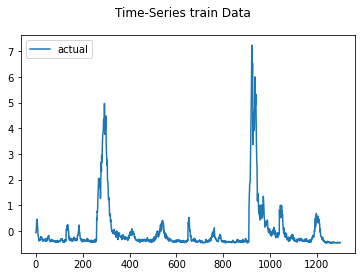

2023-03-15 04:14:20.102974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 04:14:20.103028: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 04:14:20.103057: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-15 04:14:20.103418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 04:14:20.200385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 44.798
Test RMSE: 86.018
Test sMAPE: 93.685
Test R Squared: -6.656
{'mae': 44.79768317648859, 'rmse': 86.01799279863643, 'smape': 93.68500827263571, 'r2': -6.656329403172475}


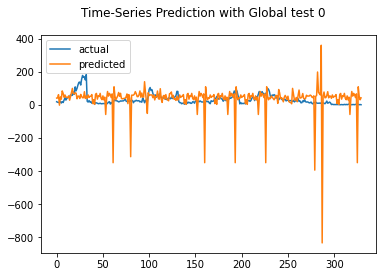

Test MAE: 44.098
Test RMSE: 83.764
Test sMAPE: 96.874
Test R Squared: -6.260
{'mae': 44.09820745704752, 'rmse': 83.76392272270047, 'smape': 96.87358643159457, 'r2': -6.260324243705943}


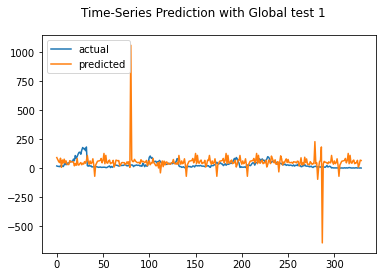

Test MAE: 38.287
Test RMSE: 54.318
Test sMAPE: 94.224
Test R Squared: -2.053
{'mae': 38.28741393690844, 'rmse': 54.31819769261488, 'smape': 94.22378288915213, 'r2': -2.05304147699415}


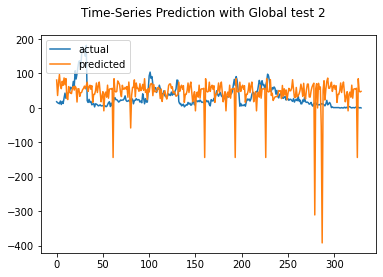

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 43.327
Test RMSE: 76.445
Test sMAPE: 105.184
Test R Squared: -5.047
{'mae': 43.32745982543989, 'rmse': 76.44536715232958, 'smape': 105.18440932677213, 'r2': -5.047060912767555}


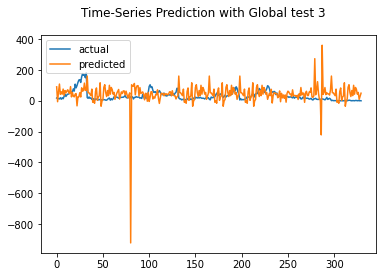

Test MAE: 62.137
Test RMSE: 163.803
Test sMAPE: 99.545
Test R Squared: -26.764
{'mae': 62.13671651491613, 'rmse': 163.80334895915882, 'smape': 99.5452798639784, 'r2': -26.76435284310029}


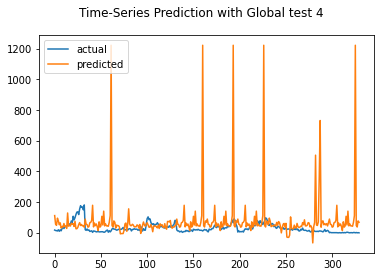

Test MAE: 55.878
Test RMSE: 140.010
Test sMAPE: 96.421
Test R Squared: -19.284
{'mae': 55.87764449426622, 'rmse': 140.0102389459523, 'smape': 96.42068864509247, 'r2': -19.284373338433802}


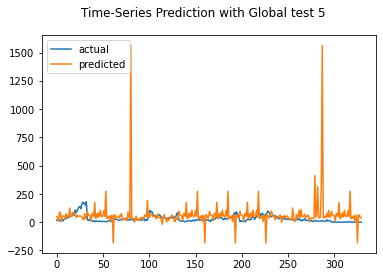

Test MAE: 54.240
Test RMSE: 112.700
Test sMAPE: 95.252
Test R Squared: -12.143
{'mae': 54.23971503864635, 'rmse': 112.70022714829602, 'smape': 95.25214963691492, 'r2': -12.14291152704625}


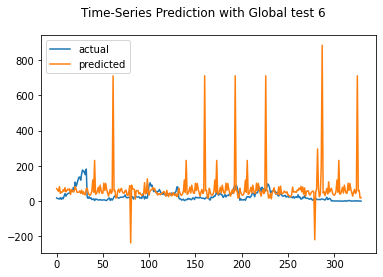

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 63.923
Test RMSE: 188.694
Test sMAPE: 112.612
Test R Squared: -35.843
{'mae': 63.92313276068731, 'rmse': 188.69387821737197, 'smape': 112.61224061006627, 'r2': -35.843223690781585}


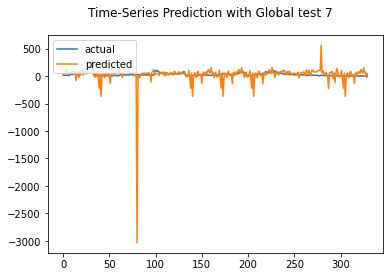

Test MAE: 49.991
Test RMSE: 99.692
Test sMAPE: 91.804
Test R Squared: -9.284
{'mae': 49.99101852792682, 'rmse': 99.69159110805475, 'smape': 91.80433937080579, 'r2': -9.283928694353449}


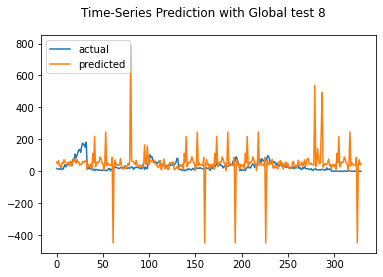

Test MAE: 47.640
Test RMSE: 92.479
Test sMAPE: 98.883
Test R Squared: -7.850
{'mae': 47.63982416842923, 'rmse': 92.47922542886127, 'smape': 98.88313620109248, 'r2': -7.849737092103114}


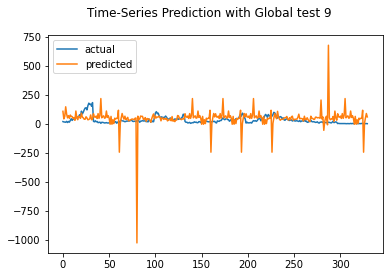

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 59.975
Test RMSE: 150.232
Test sMAPE: 112.067
Test R Squared: -22.354
{'mae': 59.974933014494, 'rmse': 150.23220322238396, 'smape': 112.06746566573504, 'r2': -22.354365595797553}


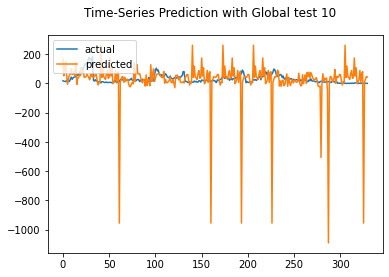

Test MAE: 52.452
Test RMSE: 103.345
Test sMAPE: 101.318
Test R Squared: -10.052
{'mae': 52.45189796650048, 'rmse': 103.34537877199152, 'smape': 101.31757009468284, 'r2': -10.05157370269416}


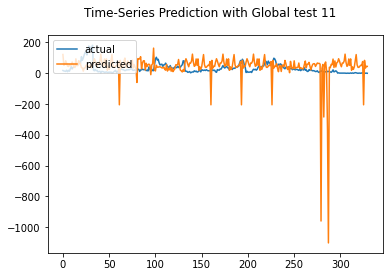

Test MAE: 61.660
Test RMSE: 180.846
Test sMAPE: 100.961
Test R Squared: -32.842
{'mae': 61.660112936568986, 'rmse': 180.8459256077782, 'smape': 100.96082890794258, 'r2': -32.842267900834386}


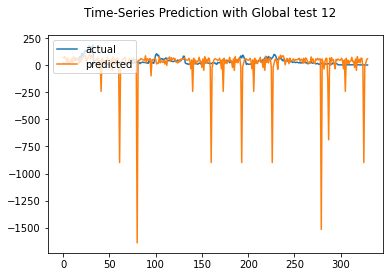

Test MAE: 39.304
Test RMSE: 70.876
Test sMAPE: 96.634
Test R Squared: -4.198
{'mae': 39.30425122493144, 'rmse': 70.8755231097058, 'smape': 96.63373304725334, 'r2': -4.197979426849359}


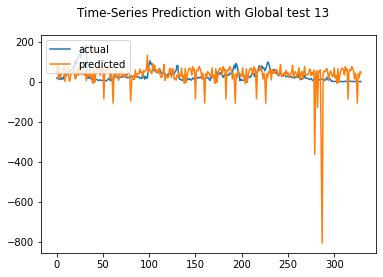

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 78.430
Test RMSE: 162.282
Test sMAPE: 118.655
Test R Squared: -26.251
{'mae': 78.4300159919894, 'rmse': 162.28174653158624, 'smape': 118.65454109663807, 'r2': -26.250931234677942}


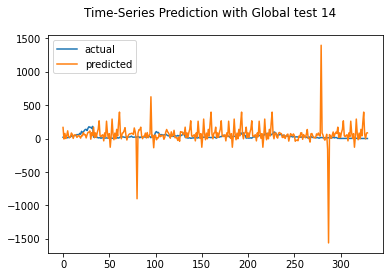

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 69.315
Test RMSE: 108.879
Test sMAPE: 117.912
Test R Squared: -11.267
{'mae': 69.31466823897578, 'rmse': 108.87936093732834, 'smape': 117.91186864946329, 'r2': -11.26685206770244}


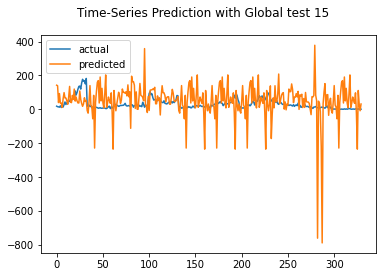

Test MAE: 66.247
Test RMSE: 163.717
Test sMAPE: 101.831
Test R Squared: -26.735
{'mae': 66.24689499681647, 'rmse': 163.71721825214766, 'smape': 101.83058465390515, 'r2': -26.735162540891707}


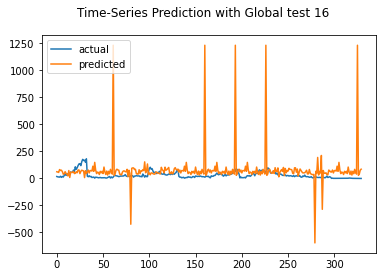

Test MAE: 65.560
Test RMSE: 157.207
Test sMAPE: 100.166
Test R Squared: -24.573
{'mae': 65.5597561041514, 'rmse': 157.20740820044102, 'smape': 100.16579457270436, 'r2': -24.573373242492124}


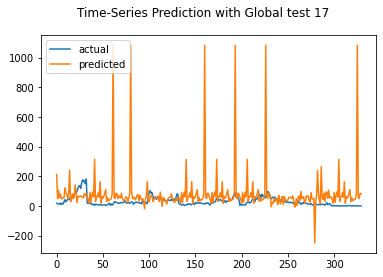

Test MAE: 45.437
Test RMSE: 73.454
Test sMAPE: 93.283
Test R Squared: -4.583
{'mae': 45.43676754344593, 'rmse': 73.45413210525689, 'smape': 93.28301267023237, 'r2': -4.583087895676811}


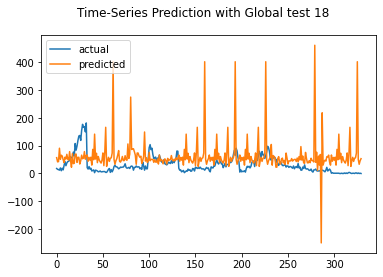

Test MAE: 39.029
Test RMSE: 62.949
Test sMAPE: 108.864
Test R Squared: -3.100
{'mae': 39.029306865370636, 'rmse': 62.948877276320104, 'smape': 108.86391746427414, 'r2': -3.100322147279429}


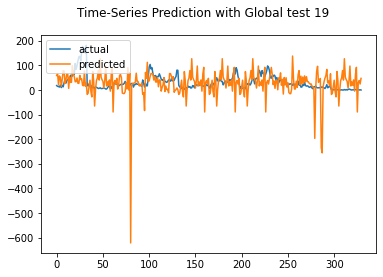

Test MAE: 50.543
Test RMSE: 92.658
Test sMAPE: 108.596
Test R Squared: -7.884
{'mae': 50.54298418016229, 'rmse': 92.65839847989062, 'smape': 108.59619711606047, 'r2': -7.88406199966701}


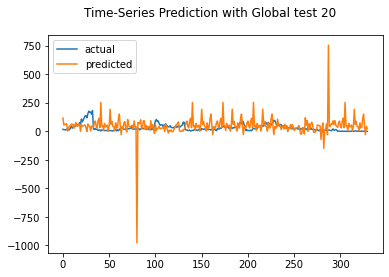

Test MAE: 62.145
Test RMSE: 154.688
Test sMAPE: 96.215
Test R Squared: -23.760
{'mae': 62.1453429814541, 'rmse': 154.6881815859683, 'smape': 96.2153196352144, 'r2': -23.760320963840535}


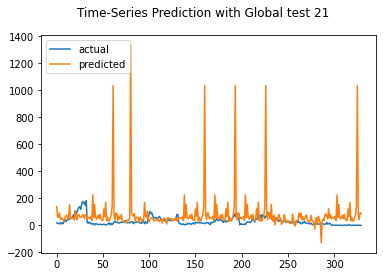

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 61.857
Test RMSE: 92.433
Test sMAPE: 110.628
Test R Squared: -7.841
{'mae': 61.856885980837276, 'rmse': 92.43266768551817, 'smape': 110.62842092345974, 'r2': -7.8408287114015}


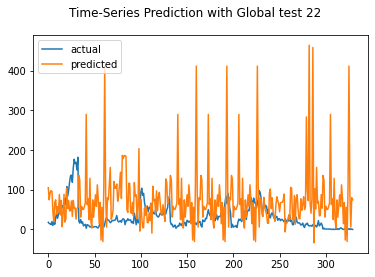

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 58.657
Test RMSE: 113.230
Test sMAPE: 112.074
Test R Squared: -12.267
{'mae': 58.65713596795545, 'rmse': 113.22966271276185, 'smape': 112.0741934799325, 'r2': -12.266685349604497}


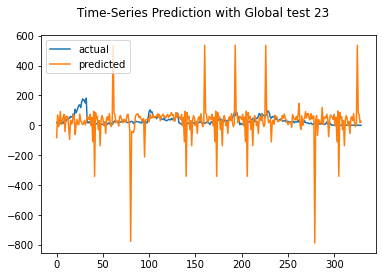

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 45.402
Test RMSE: 73.704
Test sMAPE: 100.816
Test R Squared: -4.621
{'mae': 45.402062611507645, 'rmse': 73.70401372077204, 'smape': 100.81617369139553, 'r2': -4.621138417220434}


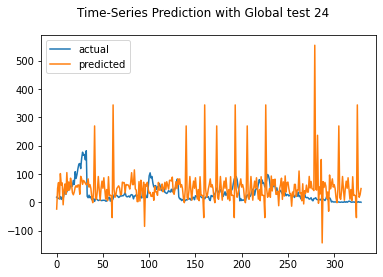

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 63.080
Test RMSE: 109.501
Test sMAPE: 109.733
Test R Squared: -11.407
{'mae': 63.07950774882779, 'rmse': 109.50111627772698, 'smape': 109.73286118899736, 'r2': -11.407351748178941}


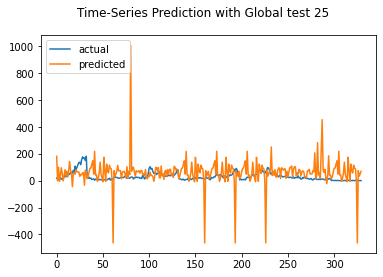

Test MAE: 37.741
Test RMSE: 47.019
Test sMAPE: 93.251
Test R Squared: -1.288
{'mae': 37.74144255898216, 'rmse': 47.01886445864049, 'smape': 93.2511772678406, 'r2': -1.2876325871525447}


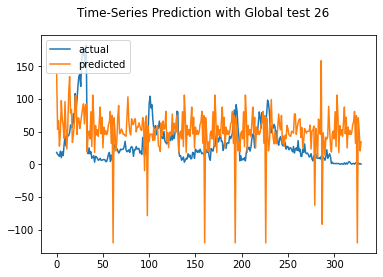

Test MAE: 61.151
Test RMSE: 192.074
Test sMAPE: 95.396
Test R Squared: -37.175
{'mae': 61.150970034165816, 'rmse': 192.07359185539173, 'smape': 95.39587731716128, 'r2': -37.17484809063952}


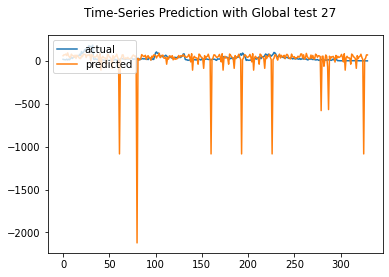

Test MAE: 41.666
Test RMSE: 70.722
Test sMAPE: 92.209
Test R Squared: -4.175
{'mae': 41.665968645341465, 'rmse': 70.72163040006085, 'smape': 92.20920976395288, 'r2': -4.175431087041665}


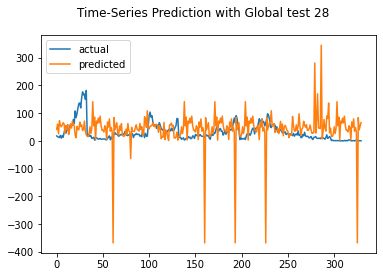

Test MAE: 45.505
Test RMSE: 95.203
Test sMAPE: 93.304
Test R Squared: -8.379
{'mae': 45.5054022156831, 'rmse': 95.20290329745096, 'smape': 93.30424058891616, 'r2': -8.378694451987856}


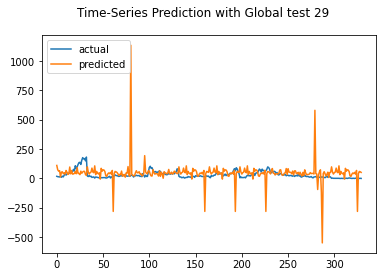

Test MAE: 49.100
Test RMSE: 84.883
Test sMAPE: 94.977
Test R Squared: -6.456
{'mae': 49.10037234190739, 'rmse': 84.88280560902822, 'smape': 94.97739417928892, 'r2': -6.455580317998612}


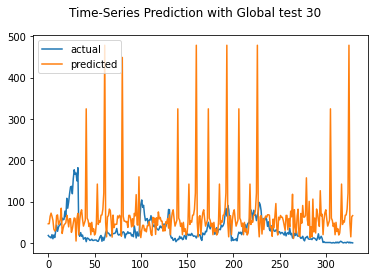

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 94.331
Test RMSE: 192.261
Test sMAPE: 128.119
Test R Squared: -37.249
{'mae': 94.33104383344903, 'rmse': 192.2612525538706, 'smape': 128.11923663740833, 'r2': -37.249480092379514}


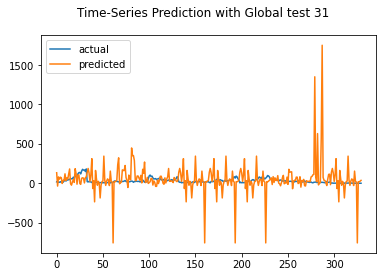

Test MAE: 50.768
Test RMSE: 127.205
Test sMAPE: 95.521
Test R Squared: -15.744
{'mae': 50.76774841605714, 'rmse': 127.20545533989683, 'smape': 95.52141279106986, 'r2': -15.74377870293143}


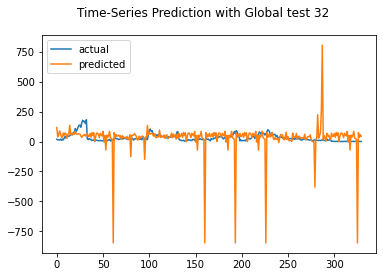

Test MAE: 47.788
Test RMSE: 89.218
Test sMAPE: 102.423
Test R Squared: -7.237
{'mae': 47.787765656095566, 'rmse': 89.21835469938816, 'smape': 102.42261107647349, 'r2': -7.236646393359971}


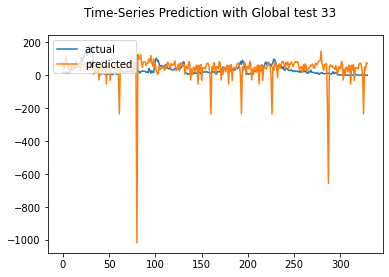

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 66.828
Test RMSE: 116.929
Test sMAPE: 115.609
Test R Squared: -13.148
{'mae': 66.82791402430246, 'rmse': 116.92938900681975, 'smape': 115.60866110877944, 'r2': -13.14781467872784}


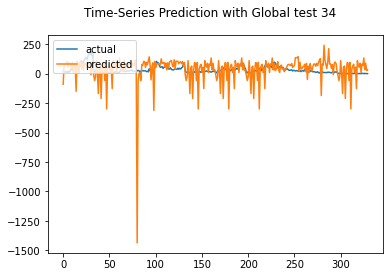

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 66.527
Test RMSE: 192.673
Test sMAPE: 128.233
Test R Squared: -37.413
{'mae': 66.52738716950019, 'rmse': 192.67293318135307, 'smape': 128.23261746544898, 'r2': -37.41345934953472}


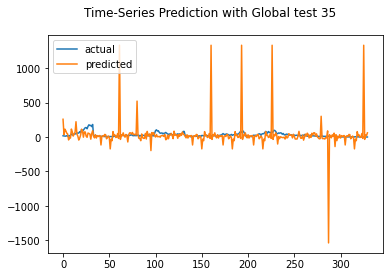

Test MAE: 48.236
Test RMSE: 86.965
Test sMAPE: 105.085
Test R Squared: -6.826
{'mae': 48.23610782687355, 'rmse': 86.96511967201782, 'smape': 105.08479039386366, 'r2': -6.825862255142372}


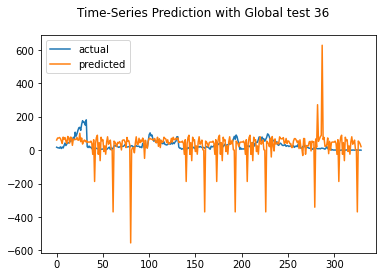

Test MAE: 57.576
Test RMSE: 112.214
Test sMAPE: 97.364
Test R Squared: -12.030
{'mae': 57.57562685157313, 'rmse': 112.21370021393665, 'smape': 97.36378759247809, 'r2': -12.02968055416312}


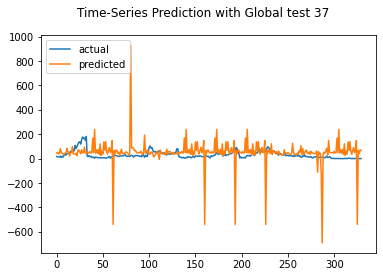

Test MAE: 46.579
Test RMSE: 117.506
Test sMAPE: 101.480
Test R Squared: -13.288
{'mae': 46.57884446698608, 'rmse': 117.50632488739632, 'smape': 101.48015131598183, 'r2': -13.287771259440825}


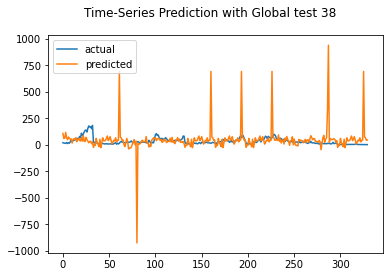

Test MAE: 52.089
Test RMSE: 106.129
Test sMAPE: 98.615
Test R Squared: -10.655
{'mae': 52.08888431895863, 'rmse': 106.12889888407143, 'smape': 98.6152972474331, 'r2': -10.654920576432886}


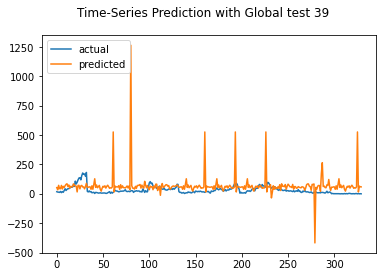

Test MAE: 57.619
Test RMSE: 111.563
Test sMAPE: 98.846
Test R Squared: -11.879
{'mae': 57.619035206644824, 'rmse': 111.56271269815741, 'smape': 98.84642323594532, 'r2': -11.878940394960342}


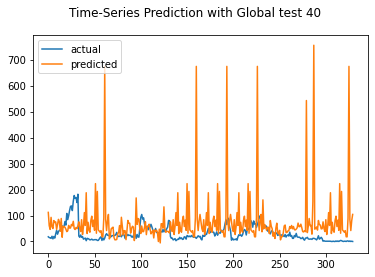

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 58.199
Test RMSE: 109.375
Test sMAPE: 122.662
Test R Squared: -11.379
{'mae': 58.19899992568023, 'rmse': 109.37541462988695, 'smape': 122.66235094419092, 'r2': -11.37888209547246}


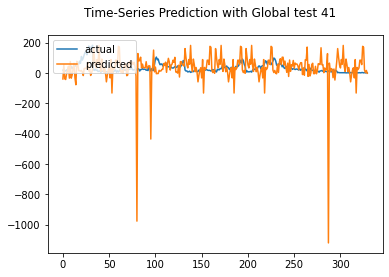

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 55.278
Test RMSE: 82.015
Test sMAPE: 110.725
Test R Squared: -5.960
{'mae': 55.277564699902676, 'rmse': 82.01519136753018, 'smape': 110.72522622060119, 'r2': -5.960342439197164}


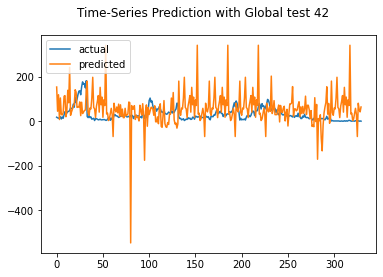

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 92.518
Test RMSE: 215.233
Test sMAPE: 118.185
Test R Squared: -46.936
{'mae': 92.51751442556129, 'rmse': 215.2326202284402, 'smape': 118.1846320572602, 'r2': -46.93560215585637}


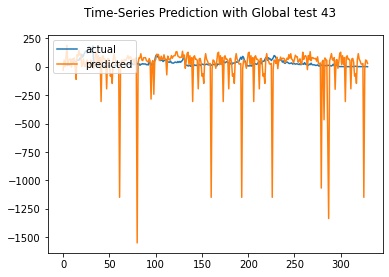

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 68.517
Test RMSE: 100.595
Test sMAPE: 116.826
Test R Squared: -9.471
{'mae': 68.51665035305601, 'rmse': 100.59498840970093, 'smape': 116.82625775747063, 'r2': -9.471157488602328}


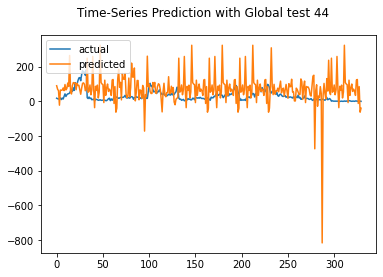

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 81.487
Test RMSE: 210.370
Test sMAPE: 120.836
Test R Squared: -44.794
{'mae': 81.48673269983495, 'rmse': 210.37031789610336, 'smape': 120.83596678788824, 'r2': -44.79424761682455}


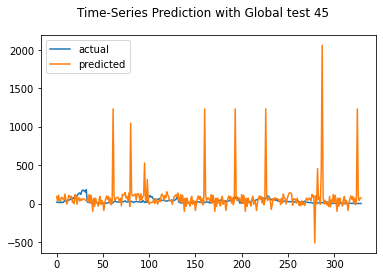

Test MAE: 47.494
Test RMSE: 68.148
Test sMAPE: 99.243
Test R Squared: -3.806
{'mae': 47.49425529015787, 'rmse': 68.14821484491867, 'smape': 99.24331590871431, 'r2': -3.805637074613637}


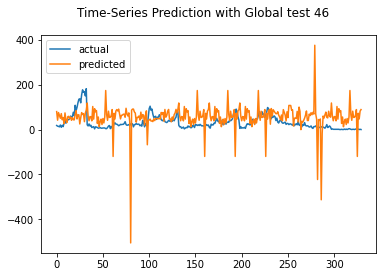

Test MAE: 54.758
Test RMSE: 103.508
Test sMAPE: 100.948
Test R Squared: -10.086
{'mae': 54.75796362703497, 'rmse': 103.50790365186313, 'smape': 100.94758240134075, 'r2': -10.086361287029616}


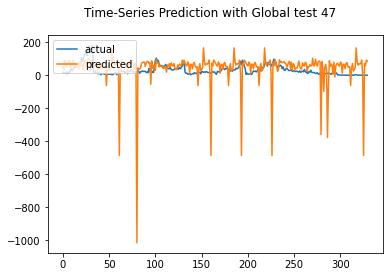

Test MAE: 41.716
Test RMSE: 56.524
Test sMAPE: 94.696
Test R Squared: -2.306
{'mae': 41.71645517060251, 'rmse': 56.523816474830596, 'smape': 94.695993370906, 'r2': -2.306016044464821}


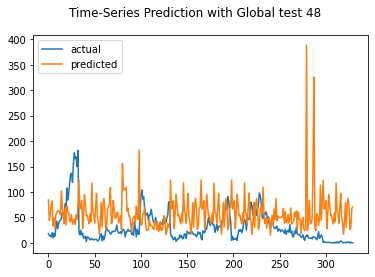

Test MAE: 43.235
Test RMSE: 66.144
Test sMAPE: 91.603
Test R Squared: -3.527
{'mae': 43.23539021231911, 'rmse': 66.14392439295777, 'smape': 91.60348937842909, 'r2': -3.52711908524544}


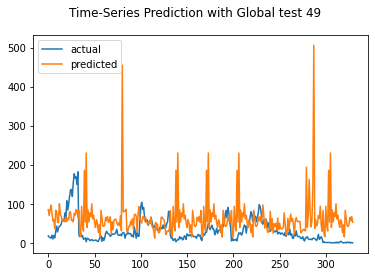

Test MAE: 50.288
Test RMSE: 84.552
Test sMAPE: 99.926
Test R Squared: -6.397
{'mae': 50.28771272113151, 'rmse': 84.55153125991195, 'smape': 99.92612659205581, 'r2': -6.39749969872841}


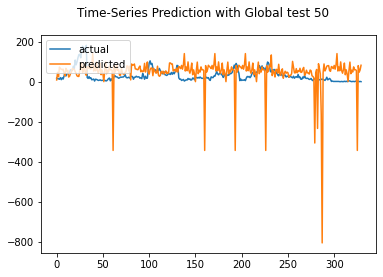

Test MAE: 59.917
Test RMSE: 144.833
Test sMAPE: 103.310
Test R Squared: -20.706
{'mae': 59.91676329428499, 'rmse': 144.83312777951576, 'smape': 103.31013986054401, 'r2': -20.705901158929844}


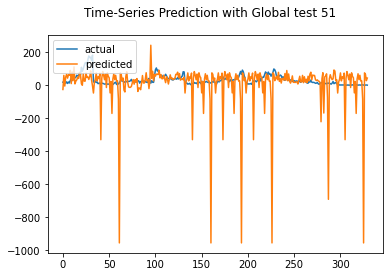

Test MAE: 49.951
Test RMSE: 86.592
Test sMAPE: 96.846
Test R Squared: -6.759
{'mae': 49.9514449003971, 'rmse': 86.59249086266705, 'smape': 96.8461584403226, 'r2': -6.758941305868518}


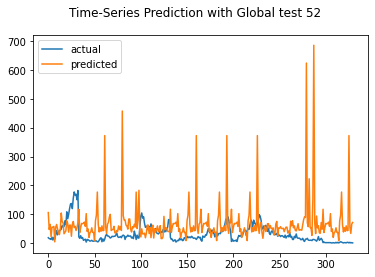

Test MAE: 47.498
Test RMSE: 84.387
Test sMAPE: 97.094
Test R Squared: -6.369
{'mae': 47.498250393434006, 'rmse': 84.38704561767909, 'smape': 97.09396080873805, 'r2': -6.368745661682692}


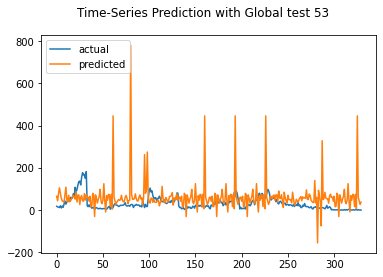

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 72.651
Test RMSE: 168.710
Test sMAPE: 127.488
Test R Squared: -28.452
{'mae': 72.65133701329204, 'rmse': 168.70963290870372, 'smape': 127.48763786666645, 'r2': -28.452472731393375}


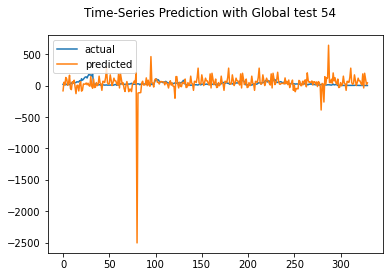

Test MAE: 36.284
Test RMSE: 78.641
Test sMAPE: 88.560
Test R Squared: -5.399
{'mae': 36.28437435554736, 'rmse': 78.64069078851931, 'smape': 88.56011507493626, 'r2': -5.399361455280346}


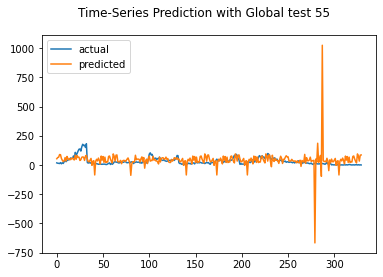

Test MAE: 40.341
Test RMSE: 77.179
Test sMAPE: 95.155
Test R Squared: -5.164
{'mae': 40.340523119225644, 'rmse': 77.17920025646286, 'smape': 95.15452647098333, 'r2': -5.163715003815301}


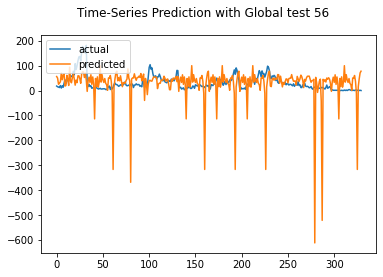

Test MAE: 54.609
Test RMSE: 153.272
Test sMAPE: 90.316
Test R Squared: -23.309
{'mae': 54.60876136716653, 'rmse': 153.27226350326913, 'smape': 90.31622209386073, 'r2': -23.30911475362259}


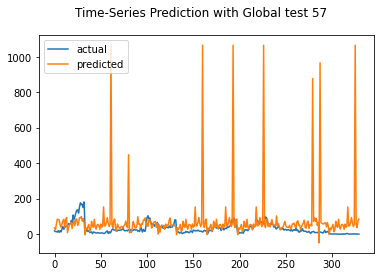

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 62.625
Test RMSE: 106.440
Test sMAPE: 107.582
Test R Squared: -10.723
{'mae': 62.62471888851036, 'rmse': 106.44019817430718, 'smape': 107.58235540199942, 'r2': -10.723393718952693}


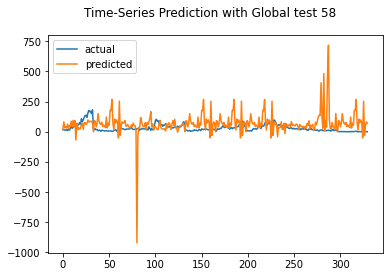

Test MAE: 38.331
Test RMSE: 62.575
Test sMAPE: 99.481
Test R Squared: -3.052
{'mae': 38.33076015674707, 'rmse': 62.57518267150711, 'smape': 99.481119686967, 'r2': -3.0517837080773083}


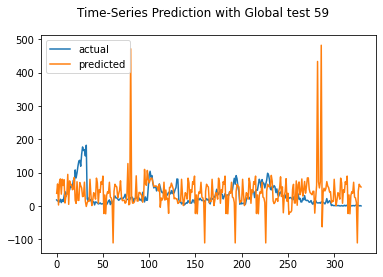

Test MAE: 53.581
Test RMSE: 80.282
Test sMAPE: 102.803
Test R Squared: -5.669
{'mae': 53.581228068380646, 'rmse': 80.2824795307657, 'smape': 102.8033235350052, 'r2': -5.669350719384859}


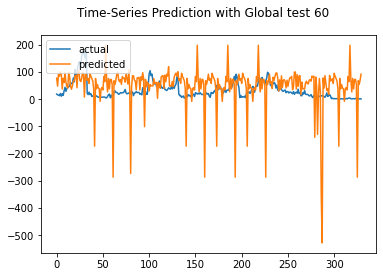

Test MAE: 52.293
Test RMSE: 141.192
Test sMAPE: 91.740
Test R Squared: -19.628
{'mae': 52.29320262020285, 'rmse': 141.19177939111748, 'smape': 91.73997766365163, 'r2': -19.628175836299974}


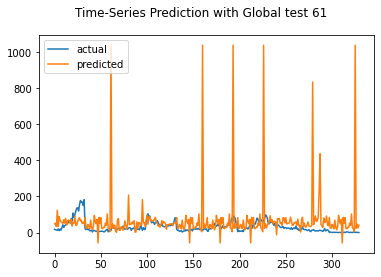

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 57.488
Test RMSE: 137.233
Test sMAPE: 109.379
Test R Squared: -18.488
{'mae': 57.48820072683421, 'rmse': 137.23328154195772, 'smape': 109.37909241226492, 'r2': -18.4877140487197}


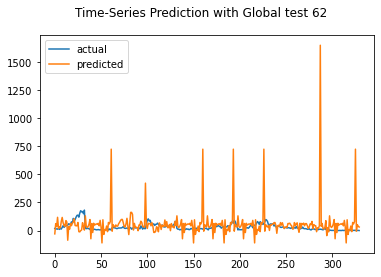

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.119
Test RMSE: 82.510
Test sMAPE: 107.394
Test R Squared: -6.045
{'mae': 46.11907743125251, 'rmse': 82.50998200397619, 'smape': 107.39446726358157, 'r2': -6.044578069740242}


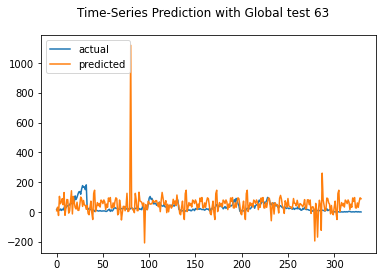

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 49.242
Test RMSE: 67.999
Test sMAPE: 109.945
Test R Squared: -3.785
{'mae': 49.2419251526847, 'rmse': 67.99937447476552, 'smape': 109.9446276631134, 'r2': -3.7846683170245408}


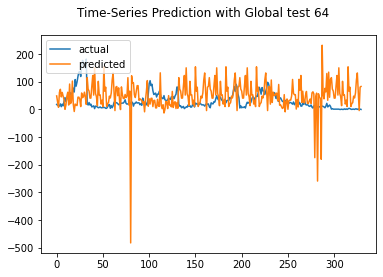

Test MAE: 51.949
Test RMSE: 121.463
Test sMAPE: 97.594
Test R Squared: -14.266
{'mae': 51.948797672806364, 'rmse': 121.46269111793862, 'smape': 97.59444323169141, 'r2': -14.266089347541126}


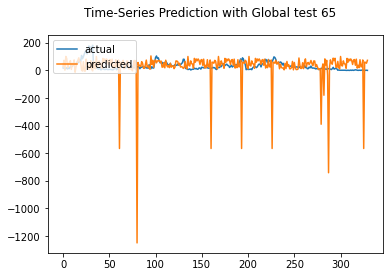

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 63.649
Test RMSE: 130.934
Test sMAPE: 125.993
Test R Squared: -16.740
{'mae': 63.648775683027324, 'rmse': 130.93356830085793, 'smape': 125.99274682920465, 'r2': -16.73960760718181}


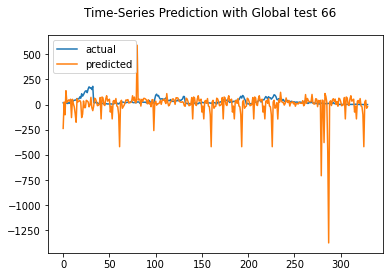

Test MAE: 42.143
Test RMSE: 71.193
Test sMAPE: 97.730
Test R Squared: -4.245
{'mae': 42.143207574974404, 'rmse': 71.19342242044479, 'smape': 97.73041573306168, 'r2': -4.244713189116445}


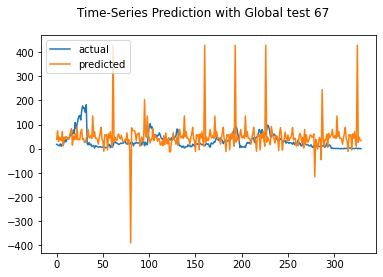

Test MAE: 56.451
Test RMSE: 141.162
Test sMAPE: 97.196
Test R Squared: -19.619
{'mae': 56.45093662251126, 'rmse': 141.1617939321934, 'smape': 97.1960975959158, 'r2': -19.619414991434617}


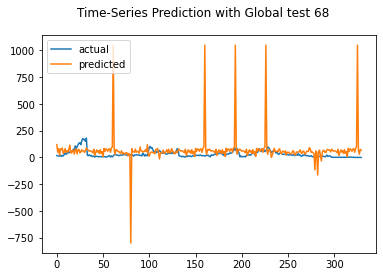

Test MAE: 48.811
Test RMSE: 73.876
Test sMAPE: 99.339
Test R Squared: -4.647
{'mae': 48.81059470068325, 'rmse': 73.8762544725062, 'smape': 99.33871258112141, 'r2': -4.647441473195555}


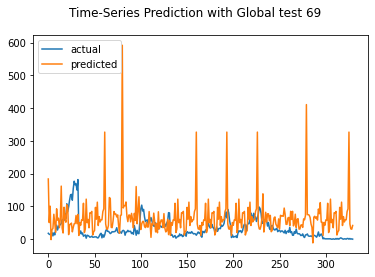

Test MAE: 43.816
Test RMSE: 79.834
Test sMAPE: 93.757
Test R Squared: -5.595
{'mae': 43.816070048375565, 'rmse': 79.83360022469846, 'smape': 93.75678574700565, 'r2': -5.594979220497132}


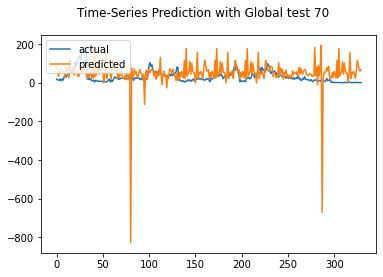

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 82.823
Test RMSE: 232.841
Test sMAPE: 115.887
Test R Squared: -55.100
{'mae': 82.82313398931062, 'rmse': 232.84077944386127, 'smape': 115.88685895479507, 'r2': -55.099642092650235}


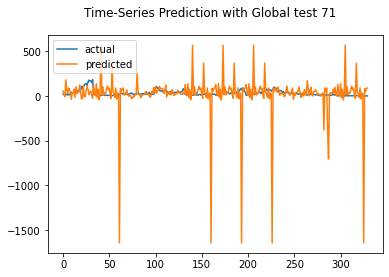

Test MAE: 46.202
Test RMSE: 64.647
Test sMAPE: 104.597
Test R Squared: -3.324
{'mae': 46.20183515982195, 'rmse': 64.6467200194042, 'smape': 104.59749251710026, 'r2': -3.32449094038164}


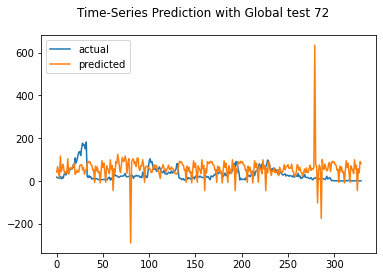

Test MAE: 46.739
Test RMSE: 94.583
Test sMAPE: 93.963
Test R Squared: -8.257
{'mae': 46.73888738552729, 'rmse': 94.58276833034716, 'smape': 93.96335574730212, 'r2': -8.25691005696331}


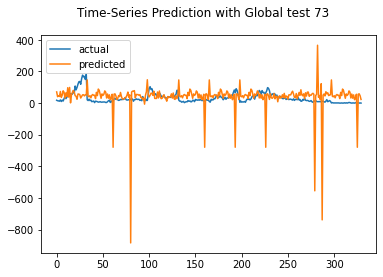

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 60.202
Test RMSE: 112.732
Test sMAPE: 101.608
Test R Squared: -12.150
{'mae': 60.20248657591415, 'rmse': 112.73199196585986, 'smape': 101.6081049405538, 'r2': -12.150321290657834}


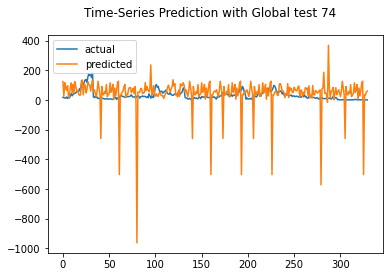

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 52.037
Test RMSE: 101.506
Test sMAPE: 120.983
Test R Squared: -9.662
{'mae': 52.03702366334019, 'rmse': 101.50634196177276, 'smape': 120.98274344896468, 'r2': -9.661746590970587}


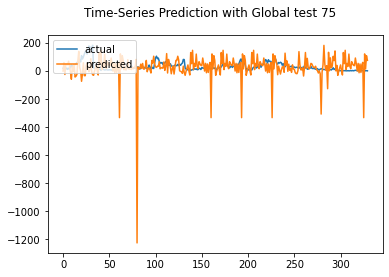

Test MAE: 44.427
Test RMSE: 62.721
Test sMAPE: 99.290
Test R Squared: -3.071
{'mae': 44.42676989237467, 'rmse': 62.72063594602623, 'smape': 99.29012886189442, 'r2': -3.0706419881931426}


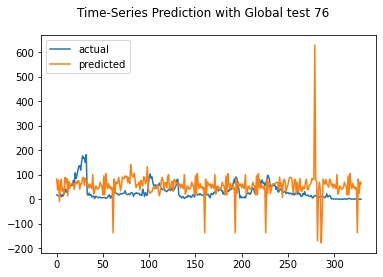

Test MAE: 54.293
Test RMSE: 99.582
Test sMAPE: 101.340
Test R Squared: -9.261
{'mae': 54.29260679505991, 'rmse': 99.58203353739981, 'smape': 101.33965138719473, 'r2': -9.261337758852418}


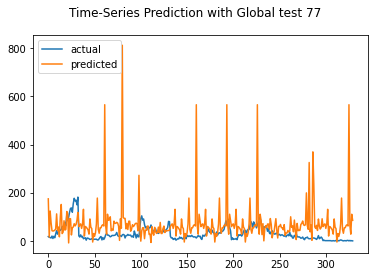

Test MAE: 45.772
Test RMSE: 93.722
Test sMAPE: 97.671
Test R Squared: -8.089
{'mae': 45.772116514227605, 'rmse': 93.72185242092426, 'smape': 97.67117588332017, 'r2': -8.089159599827479}


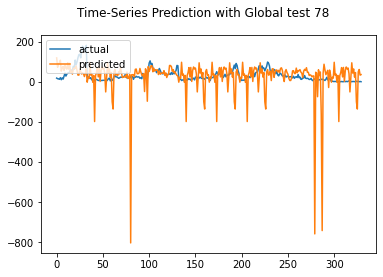

Test MAE: 54.815
Test RMSE: 82.936
Test sMAPE: 104.242
Test R Squared: -6.117
{'mae': 54.814691419673686, 'rmse': 82.93552187447828, 'smape': 104.24213698933833, 'r2': -6.117429356674568}


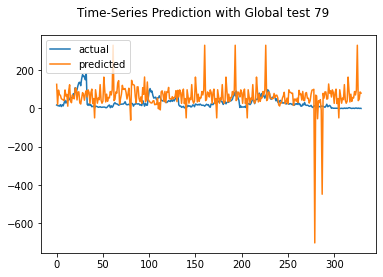

Test MAE: 49.104
Test RMSE: 114.356
Test sMAPE: 91.915
Test R Squared: -12.532
{'mae': 49.10354175712123, 'rmse': 114.35633191744739, 'smape': 91.91452888914665, 'r2': -12.532013884016978}


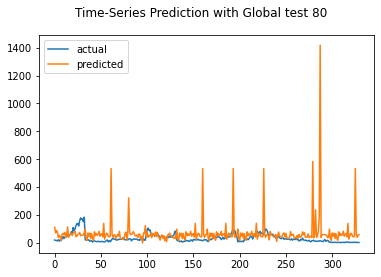

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 95.075
Test RMSE: 193.713
Test sMAPE: 122.535
Test R Squared: -37.829
{'mae': 95.07501008474466, 'rmse': 193.71251102439055, 'smape': 122.53469229192306, 'r2': -37.82910168242059}


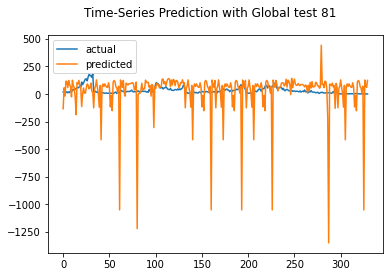

Test MAE: 33.600
Test RMSE: 48.713
Test sMAPE: 94.007
Test R Squared: -1.455
{'mae': 33.599744281443684, 'rmse': 48.712505967739126, 'smape': 94.00718608577677, 'r2': -1.455403924673674}


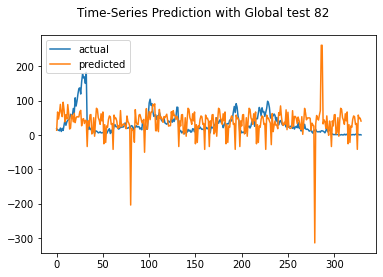

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 81.017
Test RMSE: 189.210
Test sMAPE: 120.058
Test R Squared: -36.045
{'mae': 81.01719604482254, 'rmse': 189.21046669621614, 'smape': 120.05803971941734, 'r2': -36.045231706650874}


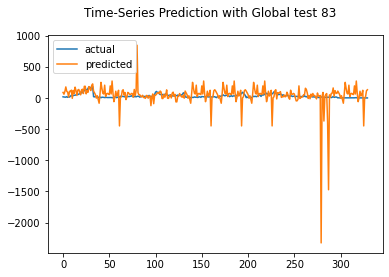

Test MAE: 61.046
Test RMSE: 173.260
Test sMAPE: 94.771
Test R Squared: -30.063
{'mae': 61.04640118750659, 'rmse': 173.25968215256208, 'smape': 94.77068147153724, 'r2': -30.06254450764292}


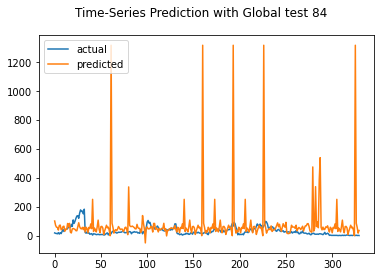

Test MAE: 42.640
Test RMSE: 60.896
Test sMAPE: 95.468
Test R Squared: -2.837
{'mae': 42.64007498856747, 'rmse': 60.89630892516801, 'smape': 95.46777661669152, 'r2': -2.8372839858373}


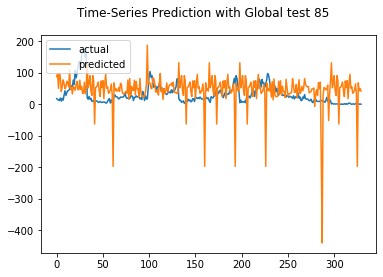

Test MAE: 36.689
Test RMSE: 57.177
Test sMAPE: 91.849
Test R Squared: -2.383
{'mae': 36.688720169934356, 'rmse': 57.17727040200885, 'smape': 91.84941716558964, 'r2': -2.382897498813713}


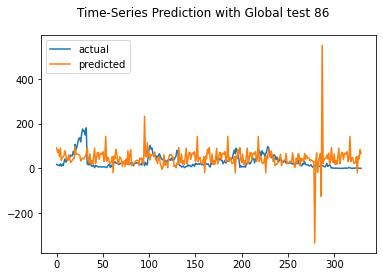

Test MAE: 46.415
Test RMSE: 112.641
Test sMAPE: 103.704
Test R Squared: -12.129
{'mae': 46.41534655238643, 'rmse': 112.6411062848462, 'smape': 103.70436058190178, 'r2': -12.129125991901603}


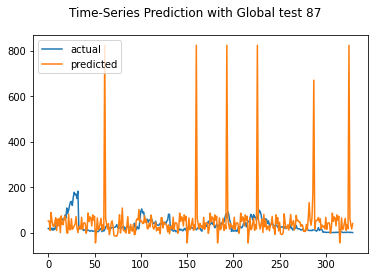

Test MAE: 53.217
Test RMSE: 120.891
Test sMAPE: 95.880
Test R Squared: -14.123
{'mae': 53.21674513238849, 'rmse': 120.89085074696528, 'smape': 95.87962597682892, 'r2': -14.122683722968176}


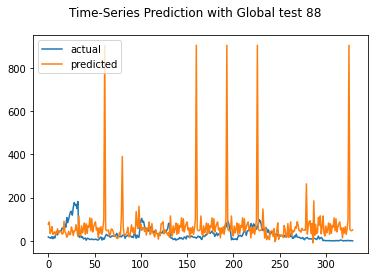

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 61.029
Test RMSE: 109.368
Test sMAPE: 107.997
Test R Squared: -11.377
{'mae': 61.02908893209515, 'rmse': 109.36782828094941, 'smape': 107.9974762505493, 'r2': -11.377164940616339}


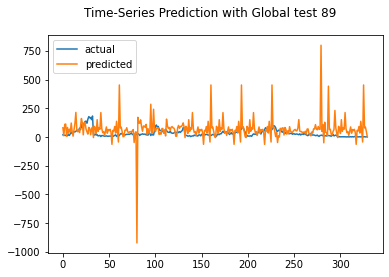

Test MAE: 47.400
Test RMSE: 69.846
Test sMAPE: 99.885
Test R Squared: -4.048
{'mae': 47.39984338789275, 'rmse': 69.8461336911397, 'smape': 99.88487925551941, 'r2': -4.048085981873026}


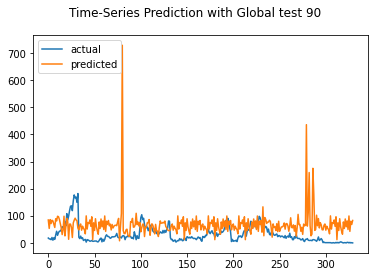

Test MAE: 55.114
Test RMSE: 133.929
Test sMAPE: 98.447
Test R Squared: -17.561
{'mae': 55.1139986365582, 'rmse': 133.9294800065932, 'smape': 98.44715899353412, 'r2': -17.56070067312968}


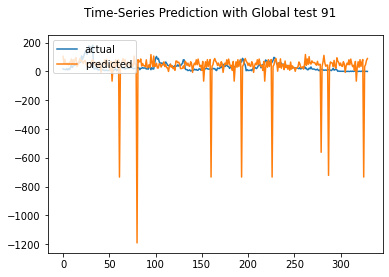

Test MAE: 46.193
Test RMSE: 83.081
Test sMAPE: 94.605
Test R Squared: -6.142
{'mae': 46.193309580196036, 'rmse': 83.08125301780221, 'smape': 94.60473303823336, 'r2': -6.142464284670156}


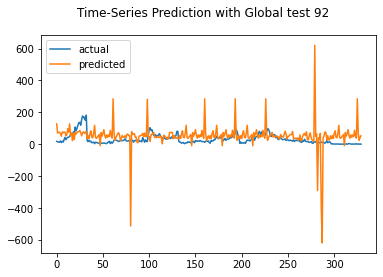

Test MAE: 53.798
Test RMSE: 156.769
Test sMAPE: 92.786
Test R Squared: -24.431
{'mae': 53.79844761815938, 'rmse': 156.7694039839304, 'smape': 92.78584756994968, 'r2': -24.431068993150706}


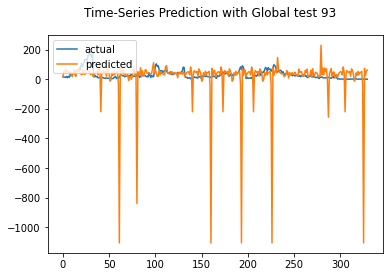

Test MAE: 68.560
Test RMSE: 189.176
Test sMAPE: 98.764
Test R Squared: -36.032
{'mae': 68.5595867026936, 'rmse': 189.17585267742794, 'smape': 98.76448772158608, 'r2': -36.03167889344097}


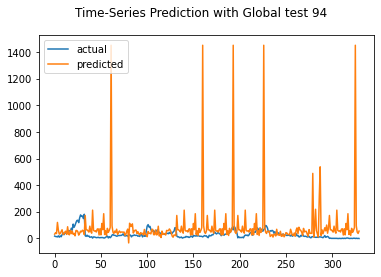

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 45.530
Test RMSE: 59.632
Test sMAPE: 105.292
Test R Squared: -2.680
{'mae': 45.530426214861144, 'rmse': 59.63170884732141, 'smape': 105.29206659281492, 'r2': -2.6795652744814817}


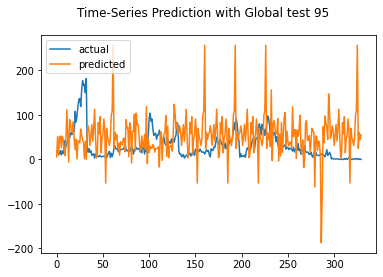

Test MAE: 53.116
Test RMSE: 133.143
Test sMAPE: 94.166
Test R Squared: -17.343
{'mae': 53.116032831957845, 'rmse': 133.14312091487577, 'smape': 94.1660577133864, 'r2': -17.343384399285963}


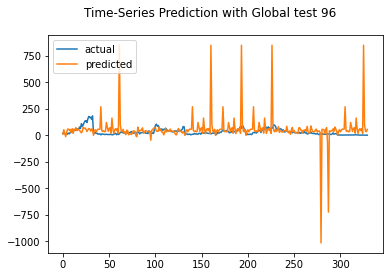

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.633
Test RMSE: 65.019
Test sMAPE: 105.329
Test R Squared: -3.374
{'mae': 44.63347435503295, 'rmse': 65.01907866285607, 'smape': 105.32941001297897, 'r2': -3.3744516824747786}


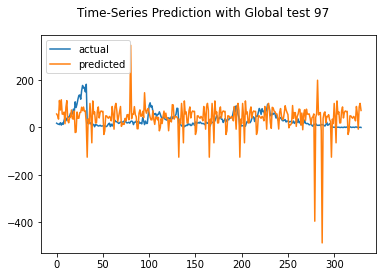

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 107.074
Test RMSE: 313.091
Test sMAPE: 118.564
Test R Squared: -100.434
{'mae': 107.07377623816332, 'rmse': 313.09056429642015, 'smape': 118.56362207423297, 'r2': -100.43362825544367}


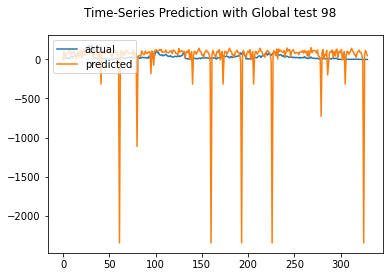

Test MAE: 46.960
Test RMSE: 89.606
Test sMAPE: 94.834
Test R Squared: -7.308
{'mae': 46.95973950154853, 'rmse': 89.60625790091353, 'smape': 94.83446362543738, 'r2': -7.308424609118205}


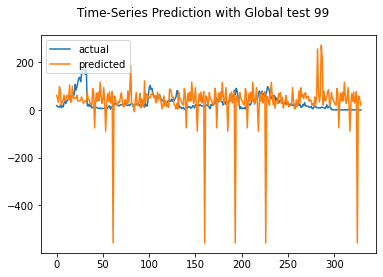

rmse : average=113.160, std=47.278
mae : average=54.837, std=13.373
smape : average=102.895, std=9.742
r2 : average=-14.563, std=14.426


([113.1604808643668, 47.27841752222534],
 [54.8367409833021, 13.373070913119813],
 [102.89462019845028, 9.742037166582215],
 [-14.563437388307358, 14.426196097918977])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')